In [422]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch # entire library
import torch.nn as nn # all neural network moduals, e.g., linear, convolutional, loss function
import torch.optim as optim # optimization function
import torch.nn.functional as F # all functions that do not have parameters, e.g., Relu, Tanh, etc
from torch.utils.data import DataLoader # easier data management
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch.autograd import Function
from IPython import embed
import pandas.tseries.offsets as offsets
import torch
from statsmodels.tools.eval_measures import rmse
import statsmodels.api as sm

In [2]:
def mae(y,yh):
    return np.mean(np.abs(y-yh))

In [3]:
dftar1 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_1/Firing1.xlsx",parse_dates=[1],index_col=1)
dftar2 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_2/Firing2.xlsx",parse_dates=[1],index_col=1, skipfooter=1)
dftar3 = pd.read_excel("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/Firing/TrueValue.xlsx",parse_dates=[1],index_col=1)
dftar1 = dftar1.groupby(level=0).first()
dftar2 = dftar2.groupby(level=0).first()
dftar3 = dftar3.groupby(level=0).first()
y1 = dftar1.iloc[:,1].values
y2 = dftar2.iloc[:,1].values
y3 = dftar3.iloc[:,1].values
df1 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_1/8F_20190802_20200801_PV.hdf","df")
df2 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS/Data_2/8F_20201106_20210418_PV.hdf","xls_df")
df2[['R8FF22.PV','R8FF32.PV', 'R8FF5.PV']] = df2[['R8FF22.PV','R8FF32.PV', 'R8FF5.PV']].apply(pd.to_numeric, errors='coerce')
df3 = pd.read_hdf("C:/Users\liuwe\Desktop\Daily\Research\ENEOS\Data_3/Firing/8F_20210701_20210930_PV.hdf","xls_df")
dfext1 = pd.DataFrame(columns=df1.columns)
for i in range(len(dftar1.index)):
    dfext1.loc[dftar1.index[i]]=df1[dftar1.index[i]-offsets.Minute(60):dftar1.index[i]].mean()
dfext2 = pd.DataFrame(columns=df2.columns)
for i in range(len(dftar2.index)):
    dfext2.loc[dftar2.index[i]]=df2[dftar2.index[i]-offsets.Minute(60):dftar2.index[i]].mean()
dfext3 = pd.DataFrame(columns=df3.columns)
for i in range(len(dftar3.index)):
    dfext3.loc[dftar3.index[i]]=df3[dftar3.index[i]-offsets.Minute(60):dftar3.index[i]].mean()
    irq = dfext1.quantile(0.75)-dfext1.quantile(0.25)
vars_inactive = irq.index[irq==0.0]
dfext1 = dfext1.drop(vars_inactive,axis=1)
vars_hasnan = dfext1.columns[dfext1.isnull().sum(axis=0)>0]
dfext1 = dfext1.drop(vars_hasnan,axis=1)
dfext1 = dfext1.drop('8FHC2.OP',axis=1) # missing values
dfext2 = dfext2[dfext1.columns]
dfext3 = dfext3[dfext1.columns]
zero_column = dfext2.columns[(dfext2 == 0).sum(axis=0)>5]
dfext2[zero_column] = dfext2[zero_column].replace(0,dfext2[zero_column].mean())
nan_column = dfext2.columns[dfext2.isnull().sum(axis=0)>0]
dfext2[nan_column] = dfext2[nan_column].replace(np.nan,dfext2[nan_column].mean())
print(dfext1.shape)
print(dfext2.shape)
print(dfext3.shape)

(349, 118)
(141, 118)
(31, 118)


In [384]:
scaler = StandardScaler()
scaler.fit(dfext1.values)
X_1 = scaler.transform(dfext1.values)
X_2 = scaler.transform(dfext2.values)
X_3 = scaler.transform(dfext3.values)

In [35]:
def seed_worker(worker_seed):
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    torch.manual_seed(worker_seed)

def data_loader(X, y, batch_size, seed):
    X, y = torch.Tensor(X), torch.Tensor(y)
    data = TensorDataset(X, y)
    g = torch.Generator()
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False, worker_init_fn=seed_worker(seed), drop_last=False, generator=g)
    return data_loader

In [415]:
source_data_loader = data_loader(X_1, y1.reshape((-1,1)), batch_size=30, seed=0)
target_data_loader = data_loader(X_2, y2.reshape((-1,1)), batch_size=10, seed=0)
target2_data_loader = data_loader(X_3, y3.reshape((-1,1)), batch_size=5, seed=0)

In [526]:
class FeatureExtractor(nn.Module):
    def __init__(self, input_size=None, hidden_size=None):
        super(FeatureExtractor, self).__init__()
        self.fc1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.fc2 = nn.Linear(in_features=hidden_size, out_features=3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return x

# Define the regression-specific output layer
class RegressionOutput(nn.Module):
    def __init__(self):
        super(RegressionOutput, self).__init__()
        self.fc_output = nn.Linear(in_features=3, out_features=1)
    
    def forward(self, x):
        return self.fc_output(x)

# Define the DeepCORAL loss
def deepcoral_loss(source_features, target_features):
    source_covariance = torch.matmul(source_features.T, source_features)
    target_covariance = torch.matmul(target_features.T, target_features)
    loss = torch.sum((source_covariance - target_covariance) ** 2) / (4 * source_covariance.size(0) ** 2)
    return loss 

In [371]:
def Model_train(num_epochs=50, input_size=None, hidden_size=None, lr=None):
# Initialize the feature extractor and optimizer
    t_loss, c_loss, r_loss = [], [], []
    feature_extractor = FeatureExtractor(input_size,hidden_size)
    regression_output = RegressionOutput()
    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(regression_output.parameters()), lr=lr)
    regression_loss = nn.MSELoss()
    
    # Training loop
    for epoch in range(num_epochs):
        for source_batch, target_batch in zip(source_data_loader, target_data_loader):
            source_x, source_y = source_batch
            target_x, target_y = target_batch
            source_features = feature_extractor(source_x)
            target_features = feature_extractor(target_x)
    
            coral_loss = deepcoral_loss(source_features, target_features)
            reg_loss = regression_loss(regression_output(source_features), source_y)
    
            total_loss = 0.2 * coral_loss + 0.8 * reg_loss
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()
        
        c_loss.append(coral_loss.item())
        r_loss.append(reg_loss.item())
        t_loss.append(total_loss.item())
        if epoch+1<10 or (epoch+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] - Total Loss: {total_loss:.4f} - CORAL Loss: {coral_loss:.4f} - Regression Loss: {reg_loss:.4f}")

        
    return feature_extractor, regression_output, t_loss, c_loss, r_loss

In [416]:
feature_ex, reg, total_loss, coral_loss, reg_loss = Model_train(num_epochs=1000, 
                                                                input_size=118, 
                                                                hidden_size=20, 
                                                                lr = 0.001)
# One layer, 5 features

Epoch [1/1000] - Total Loss: 32234.1133 - CORAL Loss: 153676.4844 - Regression Loss: 1873.5193
Epoch [2/1000] - Total Loss: 17523.0625 - CORAL Loss: 80180.3672 - Regression Loss: 1858.7371
Epoch [3/1000] - Total Loss: 10449.6172 - CORAL Loss: 44882.0469 - Regression Loss: 1841.5094
Epoch [4/1000] - Total Loss: 6834.0664 - CORAL Loss: 26874.6680 - Regression Loss: 1823.9156
Epoch [5/1000] - Total Loss: 4901.6323 - CORAL Loss: 17271.5234 - Regression Loss: 1809.1595
Epoch [6/1000] - Total Loss: 3809.7690 - CORAL Loss: 11852.1123 - Regression Loss: 1799.1832
Epoch [7/1000] - Total Loss: 3133.8223 - CORAL Loss: 8498.5723 - Regression Loss: 1792.6349
Epoch [8/1000] - Total Loss: 2688.5381 - CORAL Loss: 6294.7563 - Regression Loss: 1786.9835
Epoch [9/1000] - Total Loss: 2382.5640 - CORAL Loss: 4788.9224 - Regression Loss: 1780.9742
Epoch [100/1000] - Total Loss: 598.7290 - CORAL Loss: 251.1118 - Regression Loss: 685.6333
Epoch [200/1000] - Total Loss: 176.5199 - CORAL Loss: 132.8378 - Regres

In [15]:
def Model_eva(feature_ex, reg, data_loader):
    feature_ex.eval()
    reg.eval()
    predictions = []
    with torch.no_grad():
        for x, y in data_loader:
            new_features = feature_ex(x)
            new_pred = reg(new_features)
            predictions = np.append(predictions, new_pred.detach().numpy().squeeze())
    return predictions

In [417]:
ytrhat = Model_eva(feature_ex, reg, source_data_loader)
ytehat2 = Model_eva(feature_ex, reg, target_data_loader)
ytehat3 = Model_eva(feature_ex, reg, target2_data_loader)
print('Training RMSE:',rmse(y1,ytrhat))
print('Training MAE:', mae(y1,ytrhat))
print('Test2 RMSE:',rmse(y2,ytehat2))
print('Test2 MAE:',mae(y2,ytehat2))
print('Test3 RMSE:',rmse(y3,ytehat3))
print('Test3 MAE:',mae(y3,ytehat3))

Training RMSE: 3.1982263267279856
Training MAE: 2.458517790523846
Test2 RMSE: 12.319502736003667
Test2 MAE: 9.6746971996118
Test3 RMSE: 15.041739156678235
Test3 MAE: 11.869163267074093


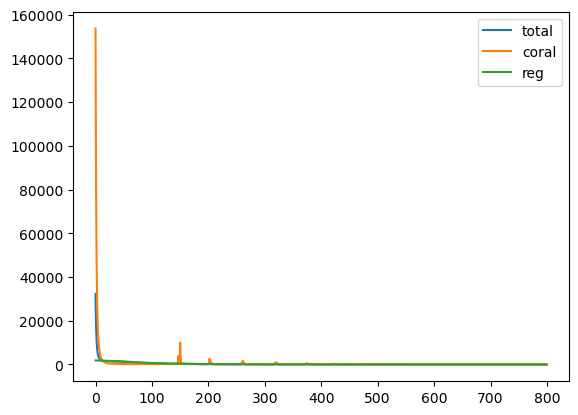

In [394]:
plt.plot(total_loss, label='total')
plt.plot(coral_loss, label='coral')
plt.plot(reg_loss, label='reg')
plt.legend()

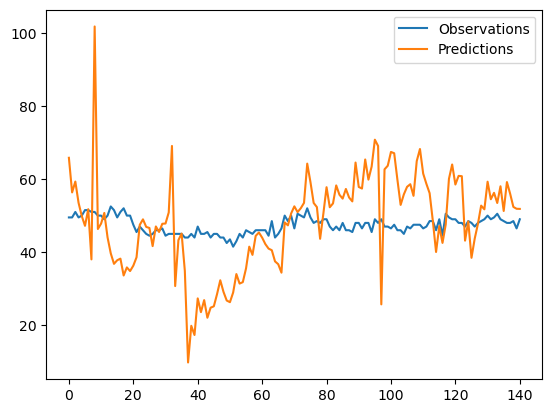

In [414]:
plt.plot(y2, label='Observations')
plt.plot(ytehat2, label='Predictions')
plt.legend()

In [418]:
excel_file_path = 'ENEOS_DeepCoral.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat2)
df.to_excel(excel_file_path, index=False)  

In [420]:
MI1 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M1.txt',header=0,index_col=0,sep='\t')
MI2 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M2.txt',header=0,sep='\t')
MI3 = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Melt Index\M3.txt',header=0,sep='\t')
MI1 = MI1.reset_index(drop=True)
print(MI1.shape, MI2.shape, MI3.shape)
MI2.drop(columns=MI2.columns[3],inplace=True)
raw_data = pd.concat([MI1.iloc[:,:12],MI2.iloc[:,:7],MI3.iloc[:,:9]],axis=1)
print(raw_data.shape)
raw_data.columns = ['f' + number for number in list(map(str,range(28)))] 
target = MI3.iloc[:,9].values
print(raw_data.shape)

(331, 13) (331, 9) (331, 10)
(331, 28)
(331, 28)


In [423]:
X_train, X_test, y_train, y_test = train_test_split(raw_data.values, target, train_size=249,shuffle=False)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [477]:
source_data_loader = data_loader(X_train, y_train.reshape((-1,1)), batch_size=20, seed=0)
target_data_loader = data_loader(X_test, y_test.reshape((-1,1)), batch_size=10, seed=0)
feature_ex, reg, total_loss, coral_loss, reg_loss = Model_train(num_epochs=100, 
                                                                input_size=28, 
                                                                hidden_size=20, 
                                                                lr = 0.001)
# one layer, 3 features

RuntimeError: mat1 and mat2 shapes cannot be multiplied (20x20 and 28x20)

In [453]:
ytrhat = Model_eva(feature_ex, reg, source_data_loader)
ytehat = Model_eva(feature_ex, reg, target_data_loader)
print('Training RMSE:',rmse(y_train,ytrhat))
print('Training MAE:', mae(y_train,ytrhat))
print('Test2 RMSE:',rmse(y_test,ytehat))
print('Test2 MAE:',mae(y_test,ytehat))

Training RMSE: 0.08538479275798017
Training MAE: 0.05561410437458156
Test2 RMSE: 0.04843899451990219
Test2 MAE: 0.03751564187320267


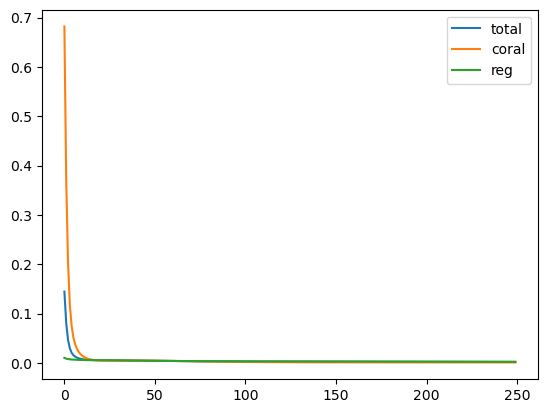

In [449]:
plt.plot(total_loss, label='total')
plt.plot(coral_loss, label='coral')
plt.plot(reg_loss, label='reg')
plt.legend()

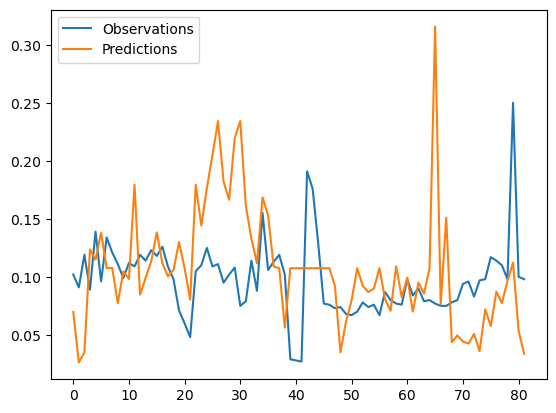

In [448]:
plt.plot(y_test, label='Observations')
plt.plot(ytehat, label='Predictions')
plt.legend()

In [454]:
excel_file_path = 'MI_DeepCoral.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat)
df.to_excel(excel_file_path, index=False)  

In [455]:
df = pd.read_csv('C:/Users\liuwe\Desktop\Daily\Research\Dataset\Penicillin Fermentation\IndPenSim_V3.csv')

# Exchange the column names 
df = df.rename(columns={'2-PAT control(PAT_ref:PAT ref)': 'Batch reference(Batch_ref:Batch ref)','Batch reference(Batch_ref:Batch ref)':'2-PAT control(PAT_ref:PAT ref)'})

# Fix the 4 hour delay by shifting 20 (20*12mins)
df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'] = df['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].shift(-20)

In [456]:
# Split the data to variables and raman, the later is not useful
variable_raman_data = np.split(df, [df.columns.get_loc("2400")], axis=1)
variable_data = variable_raman_data[0]
raman_spectra = variable_raman_data[1]
delete_variables = ['Time (h)', '1- No Raman spec',' 1-Raman spec recorded',
                    'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                    'PAA concentration offline(PAA_offline:PAA (g L^{-1}))',
                    'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
                    'Viscosity(Viscosity_offline:centPoise)',
                    '2-PAT control(PAT_ref:PAT ref)','Penicillin concentration(P:g/L)',
                    '0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)',
                    'Fault reference(Fault_ref:Fault ref)','Batch ID','Fault flag']
variable_data = variable_data.drop(delete_variables,axis=1)
# Group the data according to their batch number (1-100)
grouped_data = variable_data.groupby(['Batch reference(Batch_ref:Batch ref)'])

In [457]:
batch_id1, batch_id2 = 1, 19
batch1, batch2 = list(grouped_data)[batch_id1-1][1].iloc[:-20], list(grouped_data)[batch_id2-1][1].iloc[:-20]
offline_interp1 = batch1['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].interpolate(method='spline',order=3,limit=100, limit_direction='both')
offline_interp2 = batch2['Offline Penicillin concentration(P_offline:P(g L^{-1}))'].interpolate(method='spline',order=3,limit=100, limit_direction='both')
y_train, y_test = offline_interp1.values, offline_interp2.values

In [458]:
X_train = batch1.drop(['Offline Penicillin concentration(P_offline:P(g L^{-1}))'],axis=1)
X_test = batch2.drop(['Offline Penicillin concentration(P_offline:P(g L^{-1}))'],axis=1)

# Drop inactive columns
irq = X_train.quantile(0.75)-X_train.quantile(0.25)
vars_inactive = irq.index[irq==0.0]
X_train = X_train.drop(vars_inactive,axis=1)
X_test = X_test[X_train.columns]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [554]:
source_data_loader = data_loader(X_train, y_train.reshape((-1,1)), batch_size=20, seed=0)
target_data_loader = data_loader(X_test, y_test.reshape((-1,1)), batch_size=10, seed=0)
feature_ex, reg, total_loss, coral_loss, reg_loss = Model_train(num_epochs=35, 
                                                                input_size=20, 
                                                                hidden_size=10, 
                                                                lr = 0.001)

Epoch [1/35] - Total Loss: 660.6432 - CORAL Loss: 0.7154 - Regression Loss: 825.6252
Epoch [2/35] - Total Loss: 652.7802 - CORAL Loss: 6.4641 - Regression Loss: 814.3593
Epoch [3/35] - Total Loss: 642.2086 - CORAL Loss: 14.5262 - Regression Loss: 799.1292
Epoch [4/35] - Total Loss: 629.1335 - CORAL Loss: 66.1839 - Regression Loss: 769.8710
Epoch [5/35] - Total Loss: 640.4824 - CORAL Loss: 303.1533 - Regression Loss: 724.8147
Epoch [6/35] - Total Loss: 657.1011 - CORAL Loss: 535.6827 - Regression Loss: 687.4557
Epoch [7/35] - Total Loss: 667.7592 - CORAL Loss: 741.0251 - Regression Loss: 649.4427
Epoch [8/35] - Total Loss: 673.2714 - CORAL Loss: 910.5803 - Regression Loss: 613.9442
Epoch [9/35] - Total Loss: 677.9548 - CORAL Loss: 1075.2618 - Regression Loss: 578.6280


In [555]:
ytrhat = Model_eva(feature_ex, reg, source_data_loader)
ytehat = Model_eva(feature_ex, reg, target_data_loader)
print('Training RMSE:',rmse(y_train,ytrhat))
print('Training MAE:', mae(y_train,ytrhat))
print('Test2 RMSE:',rmse(y_test,ytehat))
print('Test2 MAE:',mae(y_test,ytehat))

Training RMSE: 5.341864018016667
Training MAE: 4.080492783780977
Test2 RMSE: 12.566504134608403
Test2 MAE: 10.677907574240507


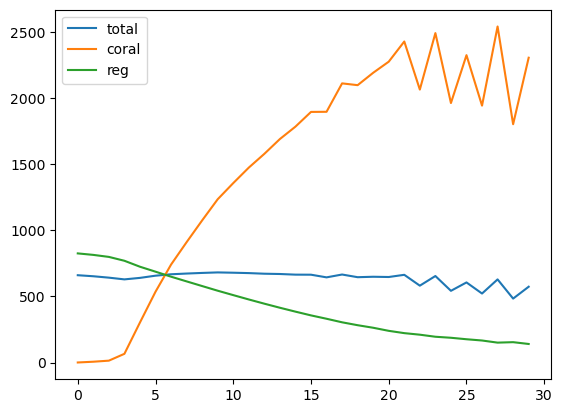

In [548]:
plt.plot(total_loss, label='total')
plt.plot(coral_loss, label='coral')
plt.plot(reg_loss, label='reg')
plt.legend()

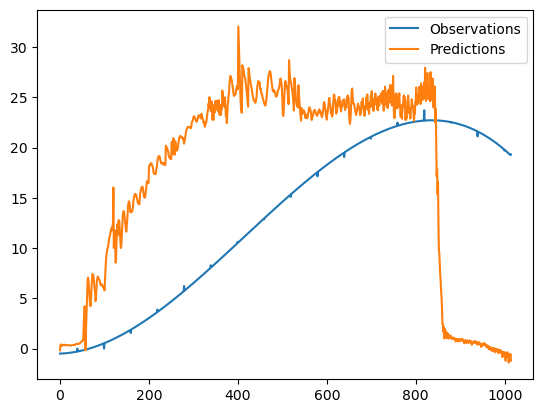

In [556]:
plt.plot(y_test, label='Observations')
plt.plot(ytehat, label='Predictions')
plt.legend()

In [ ]:
excel_file_path = 'P_DeepCoral.xlsx'  # Specify the desired file path
df = pd.DataFrame(ytehat)
df.to_excel(excel_file_path, index=False)  